In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torcheval.metrics as metrics

from networks import LinearRegression
from trainers import train, create_dataloaders
from utils import EarlyStopping

SEED = 42
DATE_FMT = "%Y-%m-%d %H:%M:%S"
LOG_FMT = "[%(asctime)s | %(levelname)s]: %(message)s"

logging.basicConfig(level=logging.INFO, format=LOG_FMT, datefmt=DATE_FMT, force=True)

plt.style.use("ggplot")
plt.rcParams.update({"text.usetex": True})

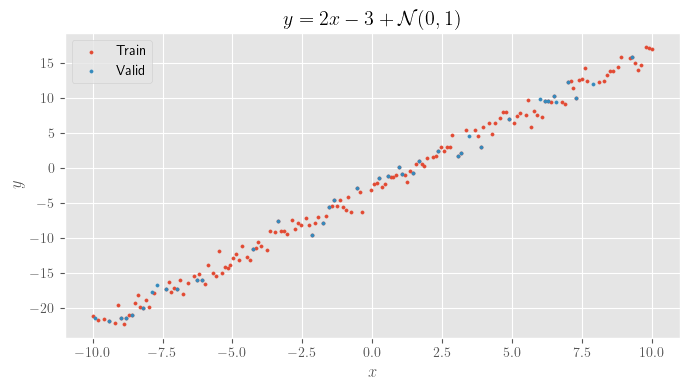

In [3]:
n_points, weight, bias = 200, 2, -3

x = torch.linspace(-10, 10, n_points).view(-1, 1)
y = weight * x.flatten() + bias + torch.randn(n_points, generator=torch.manual_seed(SEED))

train_size = int(0.8 * n_points)
valid_size = n_points - train_size

train_ids = torch.randperm(n_points)[:train_size]
valid_ids = torch.randperm(n_points)[train_size:]

x_train, y_train = x[train_ids], y[train_ids]
x_valid, y_valid = x[valid_ids], y[valid_ids]

plt.figure(figsize=(7, 4), tight_layout=True)
plt.scatter(np.asarray(x_train), np.asarray(y_train), s=5, label="Train")
plt.scatter(np.asarray(x_valid), np.asarray(y_valid), s=5, label="Valid")
plt.title(f"$y = {weight}x {bias: =+3} + \\mathcal{{N}} (0,1)$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

In [4]:
linear_regressor = LinearRegression(seed=SEED)

In [5]:
linear_regressor.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [6]:
forward = linear_regressor.forward(x_train)
predict = linear_regressor.predict(x_train)

print("Forward Pass Required Gradient:", forward.requires_grad)
print("Predict Pass Required Gradient:", predict.requires_grad)

Forward Pass Required Gradient: True
Predict Pass Required Gradient: False


In [7]:
model = LinearRegression(seed=SEED)
optimizer = optim.SGD(model.parameters())  # type: ignore
early_stopping = EarlyStopping(patience=10)
metric = metrics.MeanSquaredError()
loss = nn.MSELoss()

train_loader, valid_loader = create_dataloaders(x_train, y_train, x_valid, y_valid)
history = train(model, train_loader, valid_loader, loss, metric, optimizer, early_stopping)

[2024-09-09 18:01:42 | INFO]: Epoch:   1 | Time: 0.38s | Loss: 33.61850 | MSE: 33.61850 | Val Loss: 39.69095 | Val MSE: 36.83253
[2024-09-09 18:01:43 | INFO]: Epoch:  50 | Time: 0.00s | Loss:  2.23066 | MSE:  2.23066 | Val Loss:  2.27041 | Val MSE:  2.23150
[2024-09-09 18:01:43 | INFO]: Epoch: 100 | Time: 0.00s | Loss:  1.11536 | MSE:  1.11536 | Val Loss:  1.16517 | Val MSE:  1.18042
[2024-09-09 18:01:44 | INFO]: Epoch: 150 | Time: 0.00s | Loss:  0.96499 | MSE:  0.96499 | Val Loss:  1.01701 | Val MSE:  1.05143
[2024-09-09 18:01:44 | INFO]: Epoch: 200 | Time: 0.00s | Loss:  0.94484 | MSE:  0.94484 | Val Loss:  0.99790 | Val MSE:  1.04083
[2024-09-09 18:01:45 | INFO]: Epoch: 250 | Time: 0.00s | Loss:  0.94210 | MSE:  0.94210 | Val Loss:  0.99533 | Val MSE:  1.04083
[2024-09-09 18:01:45 | INFO]: Early Stopping...


In [8]:
model.state_dict()

OrderedDict([('weight', tensor([1.9927])), ('bias', tensor([-2.9564]))])

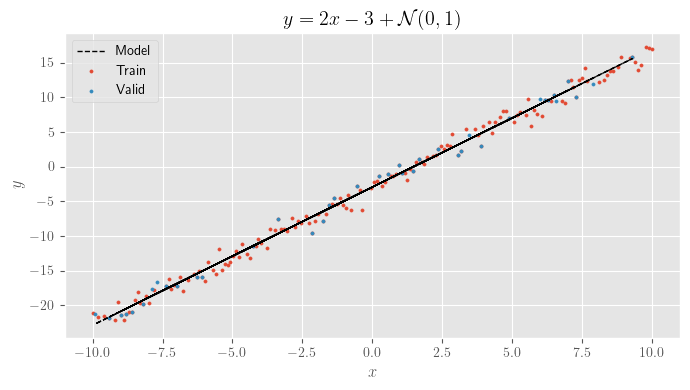

In [9]:
w, b = list(parameter.item() for parameter in model.parameters())

plt.figure(figsize=(7, 4), tight_layout=True)
plt.plot(x_valid, w * x_valid + b, label="Model", lw=1, ls="--", color="black")
plt.scatter(np.asarray(x_train), np.asarray(y_train), s=5, label="Train")
plt.scatter(np.asarray(x_valid), np.asarray(y_valid), s=5, label="Valid")
plt.title(f"$y = {weight}x {bias: =+3} + \\mathcal{{N}} (0,1)$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()